In [1]:
import re
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import QED
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from ChatDrug.task_and_evaluation import get_task_specification_dict, evaluate
from ChatDrug.task_and_evaluation.Conversational_LLMs_utils import complete

In [2]:
def parse(response):
    pattern = re.compile(r'[0-9BCOHNSOPrIFlanocs@+\.\-\[\]\(\)\\\/%=#$]{10,}')
    output_sequence_list = pattern.findall(response)
    return output_sequence_list

In [3]:
def zinc_process(zinc_path="Data/250k_rndm_zinc_drugs_clean_3.csv", num=1000, min_length=0, max_length=20):
    """
    extract top-num smiles_list & logP_list from zinc
    """
    df = pd.read_csv(zinc_path)
    df['smiles'] = df['smiles'].str.replace('\n', '')
    df['smiles'] = df['smiles'].str.replace('\r', '')
    df['length'] = df['smiles'].apply(len)
    df_ = df.sort_values(by='logP', ascending=False).reset_index()
    df_ = df_[(df_['length'] >= min_length) & (df_['length'] <= max_length)].head(num).reset_index()
    smiles_list = df_['smiles'].to_list()
    logP_list = df_['logP'].to_list()
    return smiles_list, logP_list

In [4]:
with open("Data/validation_molecule.txt", 'r') as file:
    lines = file.readlines()

smiles_list = [line.strip() for line in lines]

In [5]:
def load_dataset(val_mol_list, drug_type, task, task_specification_dict):
    if drug_type == 'molecule':
        with open(val_mol_list, 'r') as file:
            lines = file.readlines()

        test_data = [line.strip() for line in lines]
    else:
        raise NotImplementedError
    return test_data
    
def is_valid_smiles(smiles):
    """
    Check if the SMILES valid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except Exception as e:
        return False

props = ["MolLogP", "qed", "TPSA", "NumHAcceptors", "NumHDonors"]
prop_pred = [(n, func) for n, func in Descriptors.descList if n.split("_")[-1] in props]

prop2func = {}
for prop, func in prop_pred:
    prop2func[prop] = func

def cal_logP(smiles):
    assert is_valid_smiles(smiles)
    mol = Chem.MolFromSmiles(smiles)
    logP = Descriptors.MolLogP(mol)
    return logP

def cal_QED(smiles):
    assert is_valid_smiles(smiles)
    mol = Chem.MolFromSmiles(smiles)
    qed = prop2func["qed"](mol)
    # qed = QED.qed(mol)
    return qed

def cal_tPSA(smiles):
    assert is_valid_smiles(smiles)
    mol = Chem.MolFromSmiles(smiles)
    tpsa = prop2func["TPSA"](mol)
    # tpsa = Descriptors.TPSA(mol)
    return tpsa

def cal_HBA(smiles):
    assert is_valid_smiles(smiles)
    mol = Chem.MolFromSmiles(smiles)
    hba_count = prop2func["NumHAcceptors"](mol)
    # hba_count = rdMolDescriptors.CalcNumHBA(mol)
    return hba_count

def cal_HBD(smiles):
    assert is_valid_smiles(smiles)
    mol = Chem.MolFromSmiles(smiles)
    hbd_count = prop2func["NumHDonors"](mol)
    hbd_count = rdMolDescriptors.CalcNumHBD(mol)
    return hbd_count

def load_retrieval_DB(val_mol_list, task, seed):
    if task < 300:
        drug_type = 'molecule'
        DBfile = 'Data/250k_rndm_zinc_drugs_clean_3.csv'
        task_specification_dict = get_task_specification_dict(task)
        input_drug_list = load_dataset(val_mol_list, drug_type, task, task_specification_dict)
        DB = pd.read_csv(DBfile)
        DB = DB[['smiles']]
        DB = DB.rename(columns={"smiles": "sequence"})
        
        for SEQUENCE_TO_BE_MODIFIED in input_drug_list:
            DB = DB[DB['sequence'].str.find(SEQUENCE_TO_BE_MODIFIED)<0]
        DB = DB.sample(10000, random_state=seed)
    return input_drug_list, DB
    
def sim_molecule(smiles1, smiles2):
    """
    Calculate the tanimoto similarity between two SMILES strings.
    """
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        raise ValueError("Invalid SMILES string(s).")

    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return similarity

def retrieve_and_feedback(task, DB, input_drug, generated_drug, log_file, constraint, threshold_dict):
    sim_DB = DB.copy()
    sim_list = []
    for index, row in sim_DB.iterrows():
        smiles = row['sequence'].replace('\n', '')
        sim = sim_molecule(smiles, generated_drug)
        sim_list.append(sim)
    sim_DB['sim'] = sim_list
    if task < 300:
        sim_DB = sim_DB.sort_values(by=['sim'], ascending=False)
    
    for index, row in sim_DB.iterrows():
        if len(row['sequence'])>=15:
            continue
        answer = evaluate(input_drug, row['sequence'].replace('\n', ''), task, constraint, log_file, threshold_dict=threshold_dict)
        if answer:
            return row['sequence'].replace('\n', '')
    raise Exception("Sorry, Cannot fined a good one")

In [6]:
input_drug_list, DB = load_retrieval_DB("Data/validation_molecule.txt", 101, seed=0)

In [8]:
smiles = np.random.choice(smiles_list)

In [9]:
smiles

'C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1'

In [10]:
f = open("test.log", 'w', encoding="utf-8")

In [11]:
retrieve_drug = retrieve_and_feedback(task=101, DB=DB, input_drug=smiles, generated_drug=smiles, log_file=f, constraint="loose", threshold_dict=None)

In [12]:
retrieve_drug

'CNC(=S)NCCCOC'

In [16]:
# pip install accelerate
from transformers import AutoTokenizer, OPTForCausalLM

tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-6.7b")
model = OPTForCausalLM.from_pretrained("facebook/galactica-6.7b", device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [20]:
system_prompt = (
    "You are a helpful chemistry expert with extensive knowledge of drug design. "
)

messages = [{"role": "system", "content": system_prompt}]

round_index = 0
round_0_prompt = f"Question: Can you make molecule [START_I_SMILES]{smiles}[END_I_SMILES] more soluble in water? The output molecule should be similar to the input molecule.\n"
messages.append({"role": "user", "content": round_0_prompt})


input_text = messages[1]['content']
input_text = input_text+" [START_I_SMILES]"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to('cuda')

print("Input text: ", input_text)
print("messages: ", messages)

outputs = model.generate(
    input_ids,
    max_new_tokens=100,
    do_sample=True,
    top_p=0.95,
    temperature=1.0,
    use_cache=True,
    top_k=50,
    repetition_penalty=1.0,
    length_penalty=1,
)

output_text = tokenizer.decode(outputs[0])
print("raw output text: ", output_text)
output_text_list = output_text.split("[START_I_SMILES]")
output_text = output_text_list[2+round_index*3].strip()
output_text_list = output_text.split("[END_I_SMILES]")
output_text = output_text_list[0].strip()
print("output text: ", output_text)

messages.append({"role": "assistant", "content": output_text})

output_drug_list = parse(output_text)
print("output drug list: ", output_drug_list)

round_index = 1
round_x_prompt = f"Question: Your provided sequence [START_I_SMILES]{output_drug_list[0]}[END_I_SMILES] is not correct. We find a sequence [START_I_SMILES]{retrieve_drug}[END_I_SMILES] which is correct and similar to the molecule you provided. Can you give me a new molecule?\n"
messages.append({"role": "user", "content": round_x_prompt})

input_text = ""
for i in range(len(messages)-1):
    if i%2==0:
        input_text+= messages[i+1]['content']+" [START_I_SMILES]"
    if i%2==1:
        input_text+= messages[i+1]['content']+"[END_I_SMILES]"+"\n\n"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to('cuda')


print("Input text: ", input_text)
print("messages: ", messages)

outputs = model.generate(
    input_ids,
    max_new_tokens=100,
    do_sample=True,
    top_p=0.95,
    temperature=1.0,
    use_cache=True,
    top_k=50,
    repetition_penalty=1.0,
    length_penalty=1,
)

output_text = tokenizer.decode(outputs[0])
print("raw output text: ", output_text)
output_text_list = output_text.split("[START_I_SMILES]")
output_text = output_text_list[2+round_index*3].strip()
output_text_list = output_text.split("[END_I_SMILES]")
output_text = output_text_list[0].strip()
print("output text: ", output_text)

output_drug_list = parse(output_text)

print("output drug list: ", output_drug_list)

Input text:  Question: Can you make molecule [START_I_SMILES]C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1[END_I_SMILES] more soluble in water? The output molecule should be similar to the input molecule.
 [START_I_SMILES]
messages:  [{'role': 'system', 'content': 'You are a helpful chemistry expert with extensive knowledge of drug design. '}, {'role': 'user', 'content': 'Question: Can you make molecule [START_I_SMILES]C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1[END_I_SMILES] more soluble in water? The output molecule should be similar to the input molecule.\n'}]
raw output text:  Question: Can you make molecule [START_I_SMILES]C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1[END_I_SMILES] more soluble in water? The output molecule should be similar to the input molecule.
 [START_I_SMILES]CO[C@H]1CCOC1=O[END_I_SMILES]


Answer:

Yes it can, although the process of making a molecule more soluble is an art rather than a science, as it involves consideration of many factors, including solubility in wa

In [79]:
from openai import OpenAI

# client = OpenAI(api_key="sk-zgqsblbwondpoxlactagcfrqidwmlbcikrpldomyqceqpsss", base_url="https://api.siliconflow.cn/v1")
client = OpenAI(api_key="sk-1ba964a199d747c89e02cabebf9c7e37", base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")

def get_answer(prompt):
    received = False
    while not received:
        try:
            response = client.chat.completions.create(
                model="qwen-plus",
                # model="deepseek-ai/DeepSeek-V3",
                messages=[
                    {'role': 'user', 
                    'content': prompt}
                ],
                stream=False,
            )
            received = True
        except:
            continue
    return response.choices[0].message.content

In [35]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

In [ ]:
# smiles 1:  Cc1ccccc1NC(=O)/C(C#N)=C\c1cc(C)n(-c2ccc(C)c([N+](=O)[O-])c2)c1C
# R1:  Cc1cc(NC(=O)N2CCSC(C)(C)C2)ccc1C(=O)NC(C)C
# smiles 2:  O=C(N[C@@H](c1ccccc1)C1CC1)N1CCC(OCc2ccccc2F)CC1
# R2:  Cc1cc(NC(=O)N2CCSC(C)(C)C2)ccc1C(=O)NC(C)C
# similarity (s1&s2):  0.10638297872340426
# similarity (s1&r1):  0.14285714285714285
# similarity (s2&r2):  0.18518518518518517
# o1:  Cc1cc(NC(=O)N2C[C@H](C)SC2)ccc1C(=O)NC(C)C
# o2:  Cc1cc(NC(=O)N2CCC(C(O)C)CC2)ccc1C(=O)NC(C)C
# sim between o1 & o2:  0.625

In [7]:
sim_molecule("Cc1ccccc1NC(=O)/C(C#N)=C\c1cc(C)n(-c2ccc(C)c([N+](=O)[O-])c2)c1C", "Cc1cc(NC(=O)N2C[C@H](C)SC2)ccc1C(=O)NC(C)C")
sim_molecule("O=C(N[C@@H](c1ccccc1)C1CC1)N1CCC(OCc2ccccc2F)CC1", "Cc1cc(NC(=O)N2CCC(C(O)C)CC2)ccc1C(=O)NC(C)C")

0.273972602739726

In [73]:
cal_logP("O=C(C)Oc1ccccc1C(=O)O")

1.3101

In [74]:
cal_logP("O=C(C)OC(=O)O")

0.22750000000000004

In [ ]:
# Task 101





In [ ]:
# Task 102





In [62]:
root_smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(Cl)nn2)c1'
logP = cal_logP(root_smiles)
QED = cal_QED(root_smiles)
tPSA = cal_tPSA(root_smiles)
HBA = cal_HBA(root_smiles)
HBD = cal_HBD(root_smiles)
print(logP)
print(QED)
print(tPSA)
print(HBA)
print(HBD)

2.0282999999999998
0.6256354192033511
108.04
5
4


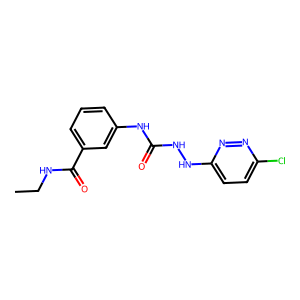

In [47]:
# root_smiles

smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(Cl)nn2)c1'
mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = 'root_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

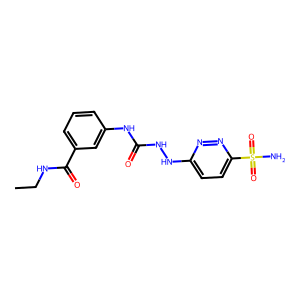

0.022300000000000986
7
0.7142857142857143


In [64]:
# 201 smiles
# Replace Chlorine Atom with Sulfonamide. 
smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(S(=O)(=O)N)nn2)c1'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '201_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))
print(cal_logP(smiles))
print(cal_HBA(smiles))
print(sim_molecule(smiles, root_smiles))

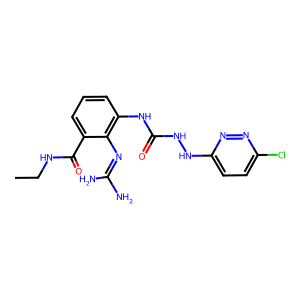

0.9332
172.44000000000003
0.5901639344262295


In [65]:
# 206 smiles
# Replace Carbon Atom with Guanidine.
smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(Cl)nn2)c1N=C(N)N'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '206_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))
print(cal_logP(smiles))
print(cal_tPSA(smiles))
print(sim_molecule(smiles, root_smiles))

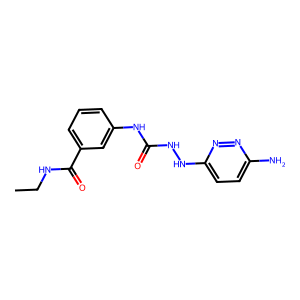

0.9570999999999998
0.7692307692307693


In [66]:
# 101 smiles
# Replace Chloroalkane with Aliphatic Amine.
smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(N)nn2)c1'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '101_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))
print(cal_logP(smiles))
print(sim_molecule(smiles, root_smiles))

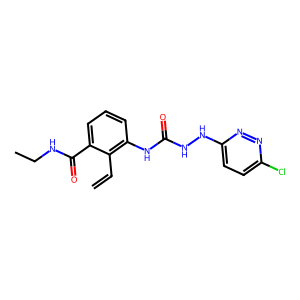

2.6713000000000013
0.6101694915254238


In [68]:
# 102 smiles
# Add an Alkene.
smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(Cl)nn2)c1C=C'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '102_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))
print(cal_logP(smiles))
print(sim_molecule(smiles, root_smiles))

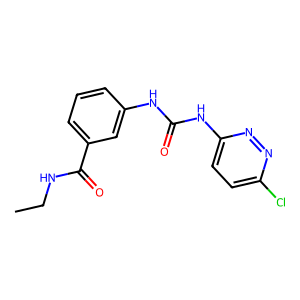

96.01
0.8163265306122449


In [71]:
# 105 smiles
# Replace Amide with Carbon Atom.
smiles = 'CCNC(=O)c1cccc(NC(=O)Nc2ccc(Cl)nn2)c1'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '105_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

print(cal_tPSA(smiles))
print(sim_molecule(smiles, root_smiles))

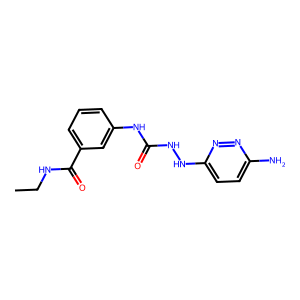

134.06
0.7692307692307693


In [72]:
# 106 smiles
# Replace Chlorine Atom with Nitrogen Atom. 
smiles = 'CCNC(=O)c1cccc(NC(=O)NNc2ccc(N)nn2)c1'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = '106_smiles.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

print(cal_tPSA(smiles))
print(sim_molecule(smiles, root_smiles))

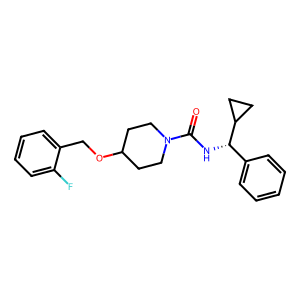

In [22]:
# smiles 2
smiles = 'O=C(N[C@@H](c1ccccc1)C1CC1)N1CCC(OCc2ccccc2F)CC1'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = 'smiles_2.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

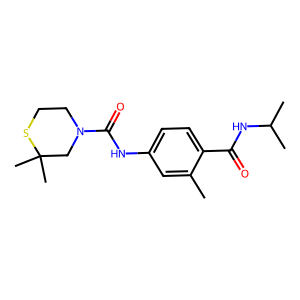

In [23]:
# r

smiles = 'Cc1cc(NC(=O)N2CCSC(C)(C)C2)ccc1C(=O)NC(C)C'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = 'r.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

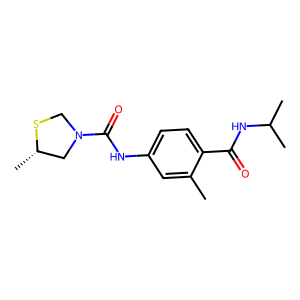

In [24]:
# o1

smiles = 'Cc1cc(NC(=O)N2C[C@H](C)SC2)ccc1C(=O)NC(C)C'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = 'o1.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

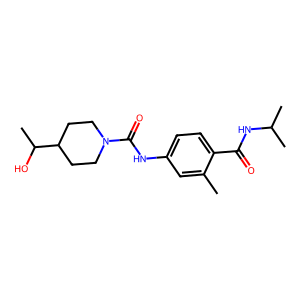

In [25]:
# o2
smiles = 'Cc1cc(NC(=O)N2CCC(C(O)C)CC2)ccc1C(=O)NC(C)C'

mol = Chem.MolFromSmiles(smiles)
Chem.AllChem.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
# drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
drawer.DrawMolecule(mol)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:', '')))
filename = 'o2.svg'
with open(filename, 'w') as f:
    f.write(svg.replace('svg:', ''))

In [33]:
sim_molecule("Cc1cc(NC(=O)N2CCSC(C)(C)C2)ccc1C(=O)NC(C)C", "Cc1cc(NC(=O)N2CCC(C(O)C)CC2)ccc1C(=O)NC(C)C")

0.603448275862069

In [ ]:
smiles_1 = "CCCN(CC#N)Cc1csc2ccccc12"
r1 = retrieve_and_feedback(task=101, DB=DB, input_drug=smiles_1, generated_drug=smiles, log_file=f, constraint="strict", threshold_dict=None)
iteration = 100
count = 0

iteration_list = list(range(1000))
pbar = tqdm(total=1000)

for i in iteration_list:
    smiles_2 = np.random.choice(smiles_list)
    if (smiles_1 == smiles_2) or (sim_molecule(smiles_1, smiles_2) >= 0.15):
        continue
    r2 = retrieve_and_feedback(task=101, DB=DB, input_drug=smiles_2, generated_drug=smiles, log_file=f, constraint="strict", threshold_dict=None)
    
    if r1 == r2:
        prompt_1 = f"Can you make molecule {smiles_1} more soluble in water? The output molecule should be similar to the input molecule. We find a sequence {r1} which is correct and similar to the molecule you provided. Give me five molecules in SMILES only and list them using bullet points. No explanation is needed."
        smiles_1_res = parse(get_answer(prompt_1))
        prompt_2 = f"Can you make molecule {smiles_2} more soluble in water? The output molecule should be similar to the input molecule. We find a sequence {r2} which is correct and similar to the molecule you provided. Give me five molecules in SMILES only and list them using bullet points. No explanation is needed."
        smiles_2_res = parse(get_answer(prompt_2))

        for smi_1 in smiles_1_res:
            if (smi_1 == smiles_1) or (not is_valid_smiles(smi_1)):
                continue
            for smi_2 in smiles_2_res:
                if (smi_2 == smiles_2) or (not is_valid_smiles(smi_2)):
                    continue
                sim = sim_molecule(smi_1, smi_2)
                if sim >= 0.5:
                    print("smiles 1: ", smiles_1)
                    print("R1: ", r1)
                    print("smiles 2: ", smiles_2)
                    print("R2: ", r2)
                    print("similarity (s1&s2): ", sim_molecule(smiles_1, smiles_2))
                    print("similarity (s1&r1): ", sim_molecule(smiles_1, r1))
                    print("similarity (s2&r2): ", sim_molecule(smiles_2, r2))
                    print("o1: ", smi_1)
                    print("o2: ", smi_2)
                    print("sim between o1 & o2: ", sim)

    pbar.update(1)
    count += 1

  7%|▋         | 67/1000 [05:21<1:05:20,  4.20s/it][00:58:42] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)cc1
[00:58:42] SMILES Parse Error: check for mistakes around position 31:
[00:58:42] @H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)
[00:58:42] ~~~~~~~~~~~~~~~~~~~~^
[00:58:42] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)cc1' for input: 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)cc1'
[00:58:42] Can't kekulize mol.  Unkekulized atoms: 8 9 11
[00:58:42] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)cc1
[00:58:42] SMILES Parse Error: check for mistakes around position 31:
[00:58:42] @H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)
[00:58:42] ~~~~~~~~~~~~~~~~~~~~^
[00:58:42] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)cc1' for input: 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(OH)cc2)S/C1=N\c1ccc(I)

smiles 1:  CCCN(CC#N)Cc1csc2ccccc12
R1:  CC(C)N1C[C@H](C(=O)NCCc2csc3ccccc23)CC1=O
smiles 2:  CN1C(=O)[C@H](CC(=O)NCCc2ccccc2)S/C1=N\c1ccc(I)cc1
R2:  CC(C)N1C[C@H](C(=O)NCCc2csc3ccccc23)CC1=O
similarity (s1&s2):  0.11538461538461539
similarity (s1&r1):  0.2878787878787879
similarity (s2&r2):  0.26582278481012656
o1:  CC(C)N1C[C@H](C(=O)NCCc2csc3ccccc23)CC1=O
o2:  CC(C)N1C[C@H](C(=O)NCCc2ccccc2)CC1=O
sim between o1 & o2:  0.6481481481481481


 26%|██▌       | 256/1000 [20:04<52:02,  4.20s/it]  [01:13:25] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](CC(=O)NCCc2ccc(I)cc2)S/C1=N\
[01:13:25] SMILES Parse Error: check for mistakes around position 42:
[01:13:25] CCc2ccc(I)cc2)S/C1=N\
[01:13:25] ~~~~~~~~~~~~~~~~~~~~^
[01:13:25] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(I)cc2)S/C1=N\' for input: 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(I)cc2)S/C1=N\'
[01:13:25] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](CC(=O)NCCc2ccc(O)cc2)S/C1=N\
[01:13:25] SMILES Parse Error: check for mistakes around position 42:
[01:13:25] CCc2ccc(O)cc2)S/C1=N\
[01:13:25] ~~~~~~~~~~~~~~~~~~~~^
[01:13:25] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(O)cc2)S/C1=N\' for input: 'CN1C(=O)[C@H](CC(=O)NCCc2ccc(O)cc2)S/C1=N\'
[01:13:25] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](CC(=O)NCCc2ccc(S)cc2)S/C1=N\
[01:13:25] SMILES Parse Error: check for mistakes around posit

In [ ]:
# smiles 1:  C[C@H](c1cccc2ccccc12)N(C(=O)CCCn1cncn1)C1CC1
# R1:  C[C@H](NC(=O)CCn1ccccc1=O)C(=O)[O-]
# smiles 2:  C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1
# R2:  C[C@H](NC(=O)CCn1ccccc1=O)C(=O)[O-]
# similarity (s1&s2):  0.24324324324324326
# similarity (s1&r1):  0.2054794520547945
# similarity (s2&r2):  0.4074074074074074

In [ ]:
prompt = "Can you make molecule C[C@H](c1cccc2ccccc12)N(C(=O)CCCn1cncn1)C1CC1 more soluble in water? The output molecule should be similar to the input molecule. We find a sequence C[C@H](NC(=O)CCn1ccccc1=O)C(=O)[O-] which is correct and similar to the molecule you provided. Give me five molecules in SMILES only and list them using bullet points. No explanation is needed."
smiles_1_res = parse(get_answer(prompt))

In [59]:
for smi in smiles_1_res:
    if smi != r1:
        if smi != smiles_1:
            print(f"sim between {smi} and r1 is {sim_molecule(smi, r1)}")

sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and r1 is 0.23809523809523808
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCC(=O)[O-])C1CC1 and r1 is 0.24193548387096775
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCO)C1CC1 and r1 is 0.20967741935483872
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CC[N+](=O)[O-])C1CC1 and r1 is 0.21212121212121213
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCOCC(=O)[O-])C1CC1 and r1 is 0.22058823529411764


In [55]:
prompt = "Can you make molecule C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C1CC1 more soluble in water? The output molecule should be similar to the input molecule. We find a sequence C[C@H](NC(=O)CCn1ccccc1=O)C(=O)[O-] which is correct and similar to the molecule you provided. Give me five molecules in SMILES only and list them using bullet points. No explanation is needed."
smiles_2_res = parse(get_answer(prompt))

In [58]:
for smi in smiles_2_res:
    if smi != r2:
        if smi != smiles_2:
            print(f"sim between {smi} and r2 is {sim_molecule(smi, r2)}")

sim between C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O-] and r2 is 0.6086956521739131
sim between C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)OC(=O)[O-] and r2 is 0.4444444444444444
sim between C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(O)=O and r2 is 0.46
sim between C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O]C(O)=O and r2 is 0.4444444444444444
sim between C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)O[C@H](O)CO and r2 is 0.42105263157894735


In [57]:
for smi_1 in smiles_1_res:
    for smi_2 in smiles_2_res:
        print(f"sim between {smi_1} and {smi_2} is {sim_molecule(smi_1, smi_2)}")

sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O-] is 0.23076923076923078
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)OC(=O)[O-] is 0.21739130434782608
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(O)=O is 0.19696969696969696
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O]C(O)=O is 0.2
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)O[C@H](O)CO is 0.1917808219178082
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O-] is 0.234375
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)OC(=O)[O-] is 0.22058823529411764
sim between C[C@H](c1cccc2ccccc12)N(C(=O)CCC(=O)[O-])C1CC1 and C[C@H](NC(=O)CCN1c2ccccc2

In [43]:
is_valid_smiles('C[C@H](NC(=O)CCN1c2ccccc2Sc2ccccc21)C(=O)[O-]')

True